## 300K Epochs Calculation

In [118]:
Ps = [10, 20, 50, 100, 500, 600, 800, 1000, 2000, 4000]
Ns = [int(P * 0.7) for P in Ps]
Ds = [int(H / 3) for H in Ns]
print(Ps)
print(Ns)
print(Ds)

[10, 20, 50, 100, 500, 600, 800, 1000, 2000, 4000]
[7, 14, 35, 70, 350, 420, 560, 700, 1400, 2800]
[2, 4, 11, 23, 116, 140, 186, 233, 466, 933]


In [169]:
import math
import sys
import torch
import os
import matplotlib.pyplot as plt
import numpy as np
import json
import torch.nn as nn
INIT_SEED = 222

import torch
import matplotlib.pyplot as plt # For visualization, not part of the core function

# def gpr_data_averaged(phi, eigs, train_y, kappa, p):
#     """
#     Phi: P * k
#     Eigs: 1*k
#     ...
#     """
#     phi = phi / torch.sqrt(torch.einsum('ij,ij->j',phi, phi))

#     II = torch.eye(eigs.shape[0], dtype=torch.float).to('cuda')
#     LL = II * eigs/(eigs + kappa/p)
#     return torch.einsum('uk,kj,vj,v->u', phi, LL, phi, train_y)
    
def compute_nngp_kernel(phis_a, phis_b, eigenvalues):
    """
    Computes the NNGP kernel matrix K(A, B) given eigenfunctions and eigenvalues.

    Args:
        phis_a (torch.tensor): Eigenfunctions evaluated at points in set A.
                             Shape (num_points_a, num_eigenfunctions).
        phis_b (torch.tensor): Eigenfunctions evaluated at points in set B.
                             Shape (num_points_b, num_eigenfunctions).
        eigenvalues (np.ndarray): 1D array of NNGP eigenvalues (lambda_k).
                                  Shape (num_eigenfunctions,).

    Returns:
        np.ndarray: The NNGP kernel matrix K(A, B).
                    Shape (num_points_a, num_points_b).
    """
    # More efficient way often, by scaling phis_a columns directly:
    scaled_phis_a = phis_a * torch.sqrt(eigenvalues)
    scaled_phis_b = phis_b * torch.sqrt(eigenvalues)
    return scaled_phis_a @ scaled_phis_b.T


def compute_gpr_nngp_torch(
    phis_train,
    y_train,
    phis_test,
    eigenvalues,
    noise_variance
):
    """
    Computes the GPR predictive mean and variance using the NNGP kernel in PyTorch.

    Args:
        phis_train (torch.Tensor): Eigenfunctions evaluated at training points.
                                   Shape (num_train_points, num_eigenfunctions).
        y_train (torch.Tensor): Training target values.
                                Shape (num_train_points,).
        phis_test (torch.Tensor): Eigenfunctions evaluated at test points.
                                  Shape (num_test_points, num_eigenfunctions).
        eigenvalues (torch.Tensor): 1D tensor of NNGP eigenvalues (lambda_k).
                                    Shape (num_eigenfunctions,).
        noise_variance (float): The observation noise variance (sigma_noise^2).

    Returns:
        tuple: A tuple containing:
            - predictive_mean (torch.Tensor): Mean predictions for test points.
                                              Shape (num_test_points,).
            - predictive_variance (torch.Tensor): Variance predictions for test points.
                                                  Shape (num_test_points,).
    """
    num_train_points = phis_train.shape[0]
    num_test_points = phis_test.shape[0]
    
    # Ensure all tensors are on the same device
    device = phis_train.device
    y_train = y_train.to(device)
    phis_test = phis_test.to(device)
    eigenvalues = eigenvalues.to(device)

    K_xx = compute_nngp_kernel(phis_train, phis_train, eigenvalues) + noise_variance * torch.eye(num_train_points, device=device)

    # Compute the inverse of (K_DD + sigma_noise^2 * I) implicitly using Cholesky decomposition
    try:
        # L is the lower-triangular Cholesky factor
        L = torch.linalg.cholesky(K_xx)
        alpha = torch.linalg.solve(L.T, torch.linalg.solve(L, y_train))
    except RuntimeError as e:
        print(f"Warning: Cholesky decomposition failed ({e}). Falling back to direct inverse.")
        # Fallback for ill-conditioned matrices, less stable/efficient for large matrices
        K_xx_inv = torch.linalg.inv(K_xx)
        alpha = K_xx_inv @ y_train

    K_xD = compute_nngp_kernel(phis_test, phis_train, eigenvalues)

    # Compute Predictive Mean
    predictive_mean = K_xD @ alpha


    return predictive_mean
    
    
def gpr_dot_product_explicit(train_x, train_y, test_x, sigma_0_sq):
    """
    Computes Gaussian Process Regression mean and standard deviation using explicit formulas
    with a Dot Product Kernel.

    Args:
        train_x (torch.Tensor): N_train x D tensor of training input features.
        train_y (torch.Tensor): N_train x 1 tensor of training target values.
        test_x (torch.Tensor): N_test x D tensor of test input features.
        sigma_0_sq (float or torch.Tensor): The sigma_0^2 hyperparameter for the DotProduct kernel.
                                            This is NOT trained, you provide its value.
        noise_var (float or torch.Tensor): The observational noise variance (added to diagonal).
                                           This is NOT trained, you provide its value.

    Returns:
        tuple: (mu_pred, sigma_pred)
            mu_pred (torch.Tensor): N_test x 1 tensor of predicted means.
            sigma_pred (torch.Tensor): N_test x 1 tensor of predicted standard deviations.
    """

  
    sigma_0_sq = torch.tensor(sigma_0_sq, dtype=torch.float32, device=train_x.device)

    # 1. Define the DotProduct kernel function (helper within the main function)
    def dot_product_kernel_torch(X1, X2):
        """
        Computes the DotProduct kernel matrix K(X1, X2) using PyTorch.
        k(xi, xj) = xi @ xj.T
        """
        a = X1 / X1.shape[1]**0.5
        b = X2 / X2.shape[1]**0.5
        return a @ b.T

    K_xx = dot_product_kernel_torch(train_x, train_x) + sigma_0_sq * torch.eye(train_x.shape[0], device=train_x.device)

    K_xstar_x = dot_product_kernel_torch(test_x, train_x)

    jitter = 1e-6 * torch.eye(train_x.shape[0], device=train_x.device)
    try:
        K_xx_inv = torch.linalg.inv(K_xx + jitter)
    except torch.linalg.LinAlgError as e:
        print(f"Error: K_xx is singular or ill-conditioned even with jitter: {e}")
        raise

    # 4. Predict Mean (mu_pred)
    # Formula: mu_pred = K(X_test, X_train) @ K(X_train, X_train)^-1 @ y_train
    mu_pred = K_xstar_x @ K_xx_inv @ train_y

    return mu_pred

class FCN_2_layers(nn.Module):
      def __init__(self, d,N,init_out,init_hidden,activation, init_seed=None):
        super().__init__()
        if init_seed is not None:
            torch.manual_seed(INIT_SEED)
        self.lin1 = nn.Linear(d,N, bias=False)
        self.lin2 = nn.Linear(N,1, bias=False)
        self.activation=activation
        self.N = N
        self.d = d
        #np.random.seed(5)
        nn.init.normal_(self.lin1.weight,0,(init_hidden)**0.5)
        nn.init.normal_(self.lin2.weight,0,(init_out)**0.5)

      def forward(self, x):
        x = self.lin1(x)

        res = self.lin2(torch.flatten(x, start_dim=1))
        return res


def activation(x):
    return x

current_dir = os.path.dirname(os.path.abspath('.'))
parent_dir = os.path.dirname(current_dir)
sys.path.append(parent_dir)

#   # I trained one network per set of hyperparameters
#   def find_net0_files_os_walk(parent_dir):
#       found_files = []
#       for root, dir, files in os.walk(parent_dir):
#           for file in files:
#               if file == 'netnum_0':  # Or 'net₀' if that's the exact character
#                   found_files.append(os.path.join(root, file))
#       return found_files

def find_net0_files_os_walk(base_dir = "/akiva/gpnettrain/"):
    """
    Finds files named 'netnum_0' within subdirectories of a base directory
    (defaulting to 'gptnettrain') that start with 'network_ensemble_300000'.

    Args:
        base_dir (str): The base directory to start the search from (e.g., 'gptnettrain').

    Returns:
        list[str]: A list of full paths to all found 'netnum_0' files
                   that meet the specified subdirectory condition.
                   Returns an empty list if the base directory does not exist
                   or no such files are found.
    """
    found_files = []
    target_subdir_prefix = "network_ensemble_300000"

    if not os.path.isdir(base_dir):
        print(f"Error: The base directory '{base_dir}' does not exist.")
        return []

    # First, identify the direct subdirectories that match the prefix
    qualifying_subdirs = []
    try:
        for entry in os.listdir(base_dir):
            full_path = os.path.join(base_dir, entry)
            if os.path.isdir(full_path) and entry.startswith(target_subdir_prefix):
                qualifying_subdirs.append(full_path)
    except OSError as e:
        print(f"Error accessing directory '{base_dir}': {e}")
        return []

    if not qualifying_subdirs:
        print(f"No subdirectories starting with '{target_subdir_prefix}' found directly under '{base_dir}'.")
        return []

    # Now, walk through each of these specific subdirectories
    for subdir_to_explore in qualifying_subdirs:
        for root, _, files in os.walk(subdir_to_explore):
            for filename in files:
                if filename == "netnum_0":
                    full_path = os.path.join(root, filename)
                    found_files.append(full_path)

    return found_files


def get_data(d,n,seed):
    np.random.seed(seed)
    X = torch.tensor(np.random.normal(loc=0,scale=1.,size=(n,1,d))).to(dtype=torch.float32)
    return X

Ps = [10, 20, 50, 100, 500, 600, 800, 1000, 2000, 4000]
Ns = [int(P * 0.7) for P in Ps]
Ds = [int(H / 3) for H in Ns]


train_seed = 563
test_seed = 10
theory_eigs_path = '/home/akiva/FCNX-Ensembling/GPExps/theory_eigs.json'


Menagerie_dir = os.path.join('/home/akiva/gpnettrain')
theory = None
with open(theory_eigs_path,'r') as f:
    theory = json.load(f)
lH_diffs = []
nets = find_net0_files_os_walk(Menagerie_dir)

nets = sorted(nets, key=lambda x: os.path.getctime(x))


## Some diagnostics on 300K

In [170]:
Ps = [10, 20, 50, 100, 500, 600, 800, 1000, 2000, 4000]
Ns = [int(P * 0.7) for P in Ps]
Ds = [int(H / 3) for H in Ns]

net = torch.load(nets[4])
W1 = net.lin1.weight.detach().cpu().numpy()
Ds[4]

/tmp/ipykernel_3648935/1377573279.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net = torch.load(nets[4])


116

In [171]:
1.0/Ds[4]**0.5

0.09284766908852593

In [172]:
np.var?

Signature:
np.var(
    a,
    axis=None,
    dtype=None,
    out=None,
    ddof=0,
    keepdims=<no value>,
    *,
    where=<no value>,
)
Docstring:
Compute the variance along the specified axis.

Returns the variance of the array elements, a measure of the spread of a
distribution.  The variance is computed for the flattened array by
default, otherwise over the specified axis.

Parameters
----------
a : array_like
    Array containing numbers whose variance is desired.  If `a` is not an
    array, a conversion is attempted.
axis : None or int or tuple of ints, optional
    Axis or axes along which the variance is computed.  The default is to
    compute the variance of the flattened array.

    .. versionadded:: 1.7.0

    If this is a tuple of ints, a variance is performed over multiple axes,
    instead of a single axis or all the axes as before.
dtype : data-type, optional
    Type to use in computing the variance.  For arrays of integer type
    the default is `float64`; for arra

I expect the stddev to be $0.09284766909$, while it actually is $0.0929...$. 

In [173]:
np.var(W1.flatten())

0.008648208

(array([   13.,   171.,  1534.,  6008., 12300., 12477.,  6306.,  1586.,
          190.,    15.]),
 array([-0.40128565, -0.32136208, -0.24143851, -0.16151495, -0.08159138,
        -0.00166781,  0.07825576,  0.15817933,  0.23810288,  0.31802645,
         0.39795002]),
 <BarContainer object of 10 artists>)

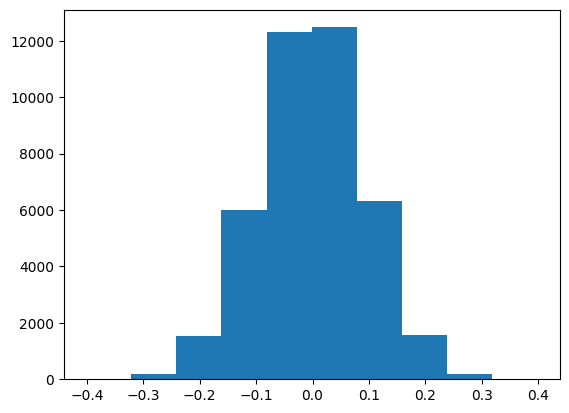

In [64]:
plt.hist(W1.flatten())

Lemme check if this discrepancy can be what is causing the discrepancy in the eigenvalues: 

In [95]:
n = torch.load(nets[4])
W1 = n.lin1.weight.detach()

P = Ps[4]
N = Ns[4]
d = Ds[4]
X = get_data(d, N, train_seed).to('cuda') # this is the train seed used in net.py
X = X.squeeze()
W1 = n.lin1.weight.detach()


/tmp/ipykernel_3648935/2085662175.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  n = torch.load(nets[4])


In [82]:
P

500

In [122]:
sq_norms = torch.sum(X**2, dim=1)  # shape (P,)
# Compute the density for each row
p = (1 / (2 * torch.pi)**(d/2)) * torch.exp(-0.5 * sq_norms) 
torch.sum(torch.exp(-0.5 * sq_norms))

tensor(9.0552e-18, device='cuda:0')

In [109]:
(1 / (2 * torch.pi)**(d/2)) * 1e47

5.07653792778479

(array([335.,   1.,   1.,   3.,   0.,   4.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,
          0.,   0.,   1.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([1.11594045e-19, 3.65867116e-03, 7.31734233e-03, 1.09760128e-02,
        1.46346847e-02, 1.82933547e-02, 2.19520256e-02, 2.56106984e-02,
        2.92693693e-02, 3.29280384e-02, 3.65867093e-02, 4.02453803e-02,
        4.39040512e-02, 4.75627258e-02, 5.12213968e-02, 5.48800677e-02,
        5.85387386e-02, 6.2197

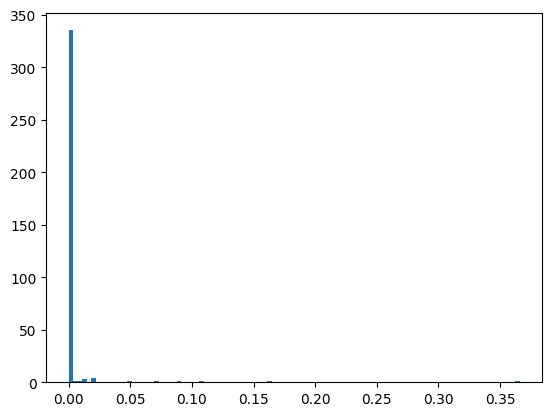

In [158]:
p = ((1 / (2 * torch.pi)**(d/2)) * 1e47 ) * (torch.exp(-0.5 * sq_norms) * 1e18) * 0.0218
dp = p.unsqueeze(1)
dp.shape
plt.hist(dp.cpu().numpy(), bins=100)

In [161]:
# Scale each row of X by the corresponding density

print(f'P: {P}, N:{N}, d:{d}')
W1 = n.lin1.weight.detach()
f = (X @ W1.T) / (P**0.5)
fm = torch.mean(f, dim=1)
hh = torch.einsum('ji,ki->jk', f, f)/N 
Ls = torch.einsum('uj,uv,vj->j', X, hh, X) / P
norm = torch.einsum('ij,ij->j',X, X) / P
lsT = Ls/norm
ls =lsT.cpu().numpy()

P: 500, N:350, d:116


Computed eig: 0.007440237328410149, Actual: 0.008620689655172414, Fibbed: 0.008648207746171865
True GPR x[0]: 1.0627483129501343
FCN2 GPR x[0]: 1.0349509716033936
Fibbed GPR x[0]: 1.0633459091186523
---


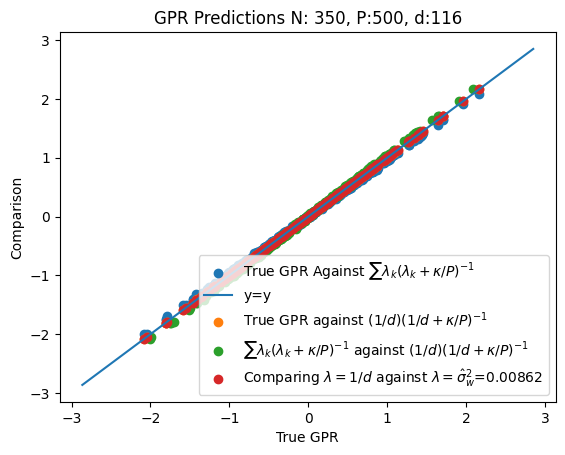

In [165]:
eigs.append(ls)
X_test_ = get_data(d, N, test_seed).to('cuda')

X_test = X_test_.squeeze()
Xn = X_test.cpu().numpy()


print(f'Computed eig: {lsT[0]}, Actual: {1/d}, Fibbed: 0.008648207746171865')


true_gpr = gpr_dot_product_explicit(X, X[:,0], X_test, 1.0).cpu().numpy()
mu_gpr = compute_gpr_nngp_torch(X, X[:,0], X_test, lsT, 1.0).cpu().numpy()

perfect_gpr = compute_gpr_nngp_torch(X, X[:,0], X_test, lsT * 0 + 1.0/d,  1.0).cpu().numpy()


fibbed_gpr = compute_gpr_nngp_torch(X, X[:,0], X_test, lsT * 0 + 0.008648207746171865,  1.0).cpu().numpy()

tru_y =  X_test[:,0].cpu().numpy()


print(f'True GPR x[0]: {true_gpr[0]}')
print(f'FCN2 GPR x[0]: {mu_gpr[0]}')
print(f'Fibbed GPR x[0]: {fibbed_gpr[0]}')

print('---')

plt.figure()
plt.title(f"GPR Predictions N: {N}, P:{P}, d:{d}")
plt.scatter(true_gpr, mu_gpr, label="True GPR Against $\sum \lambda_k(\lambda_k + \kappa/P)^{-1}$")
plt.plot(np.sort(tru_y), np.sort(tru_y), label="y=y")
plt.scatter(true_gpr, perfect_gpr, label="True GPR against $(1/d)(1/d+\kappa/P)^{-1}$")
plt.scatter(mu_gpr, perfect_gpr, label="$\sum \lambda_k(\lambda_k + \kappa/P)^{-1}$ against $(1/d)(1/d+\kappa/P)^{-1}$")
plt.scatter(perfect_gpr, fibbed_gpr, label="Comparing $\lambda = 1/d$ against $\lambda = \hat{\sigma}^2_w$=0.00862")
plt.xlabel("True GPR")
plt.ylabel("Comparison")
plt.legend()    

theorylHp = float(theory["perps"][i][1])
theorylHT = float(theory["targ"][i][1])
lH_diff = ls[0] - theorylHp
lH_diffs.append(lH_diff)

## Actual computation of 300K

/tmp/ipykernel_3648935/4273840950.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  n = torch.load(nets[i])


P: 10, N:7, d:2
Computed eig: 0.7301349639892578, Actual: 0.5
True GPR x[0]: 1.159680962562561
FCN2 GPR x[0]: 1.159680962562561
---
P: 20, N:14, d:4
Computed eig: 0.38838455080986023, Actual: 0.25
True GPR x[0]: 1.1363507509231567
FCN2 GPR x[0]: 1.1363507509231567
---
P: 50, N:35, d:11
Computed eig: 0.0926794484257698, Actual: 0.09090909090909091
True GPR x[0]: 1.022117257118225
FCN2 GPR x[0]: 1.022117257118225
---
P: 100, N:70, d:23
Computed eig: 0.03976665064692497, Actual: 0.043478260869565216
True GPR x[0]: 0.8749551773071289
FCN2 GPR x[0]: 0.8749551773071289
---
P: 500, N:350, d:116
Computed eig: 0.007440237328410149, Actual: 0.008620689655172414
True GPR x[0]: 1.0627483129501343
FCN2 GPR x[0]: 1.0627483129501343
---
P: 600, N:420, d:140
Computed eig: 0.00601676432415843, Actual: 0.007142857142857143
True GPR x[0]: 0.7100546360015869
FCN2 GPR x[0]: 0.7100546360015869
---
P: 800, N:560, d:186
Computed eig: 0.004566859919577837, Actual: 0.005376344086021506
True GPR x[0]: 0.87710237

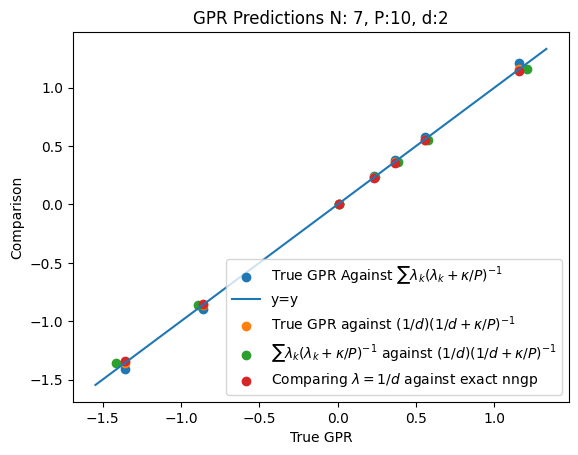

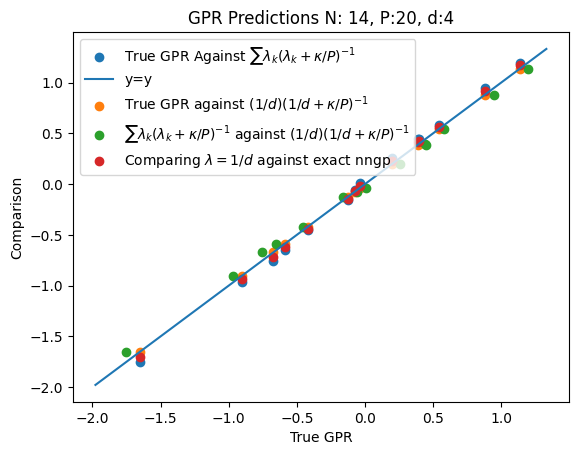

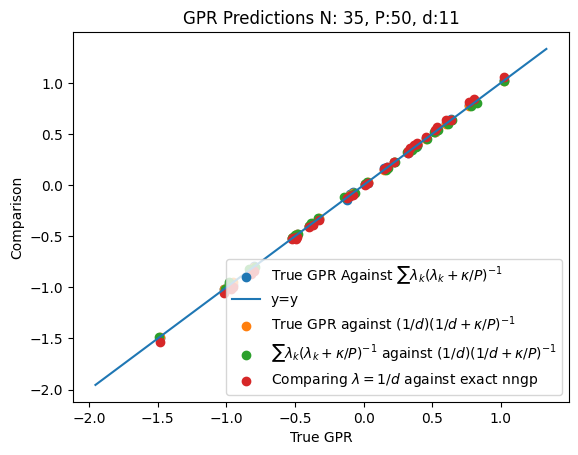

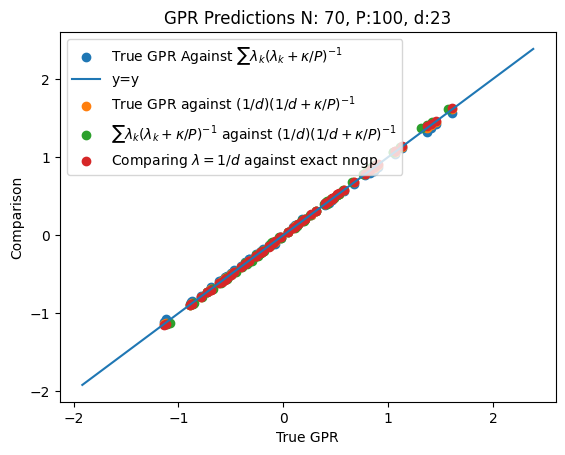

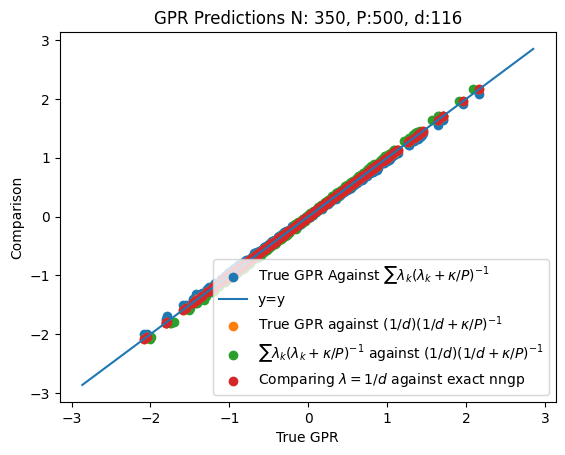

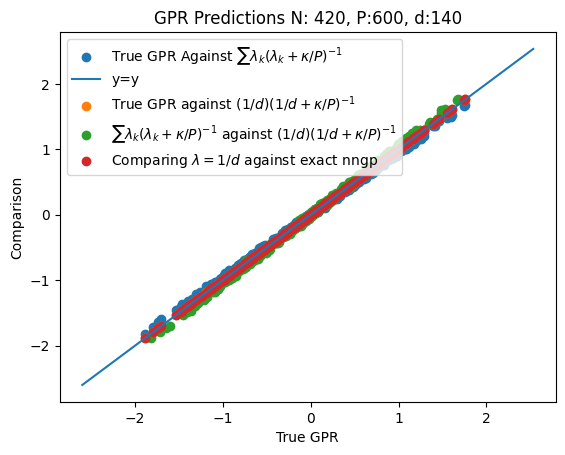

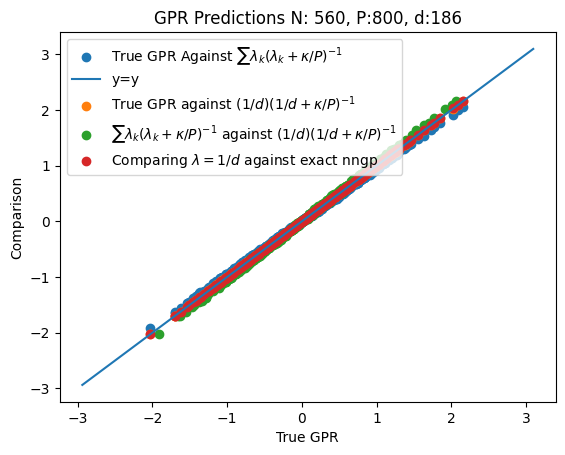

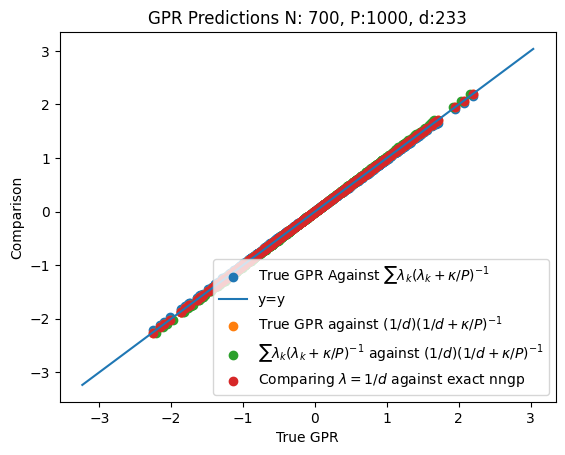

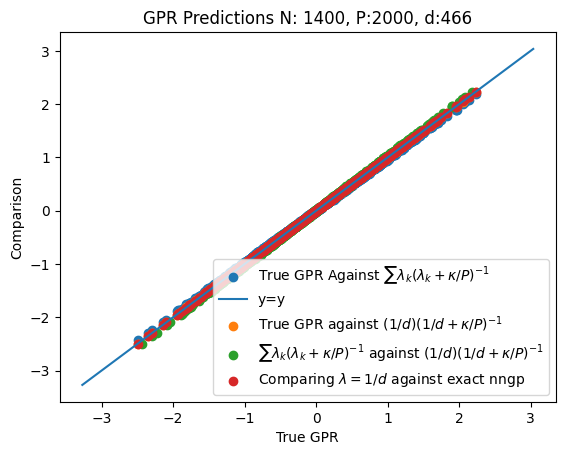

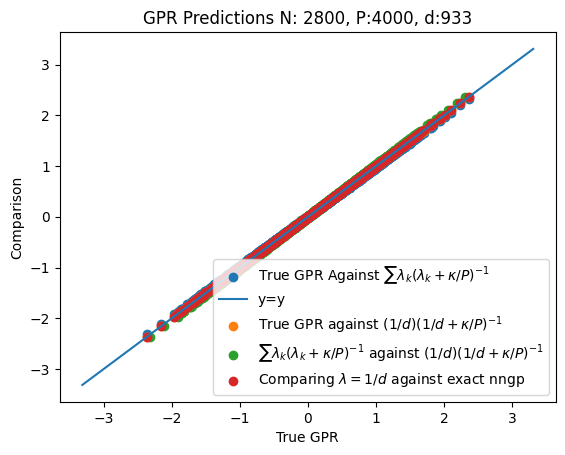

In [175]:
eigs = []
for i in range(len(nets)): 
    n = torch.load(nets[i])

    
    W1 = n.lin1.weight.detach()
    
    P = Ps[i]
    N = Ns[i]
    d = Ds[i]
    X = get_data(d, N, train_seed).to('cuda') # this is the train seed used in net.py
    X = X.squeeze()
    W1 = n.lin1.weight.detach()
    print(f'P: {P}, N:{N}, d:{d}')

    f = (X @ W1.T) / (P**0.5)
    fm = torch.mean(f, dim=1)
    hh = torch.einsum('ji,ki->jk', f, f)/N 
    Ls = torch.einsum('uj,uv,vj->j', X, hh, X) / P
    norm = torch.einsum('ij,ij->j',X, X) / P
    lsT = Ls/norm
    ls =lsT.cpu().numpy()
    eigs.append(ls)
    X_test_ = get_data(d, N, test_seed).to('cuda')
    
    X_test = X_test_.squeeze()
    Xn = X_test.cpu().numpy()

    print(f'Computed eig: {lsT[0]}, Actual: {1/d}')
    
    
    true_gpr = gpr_dot_product_explicit(X, X[:,0], X_test, 1.0).cpu().numpy()
    mu_gpr = compute_gpr_nngp_torch(X, X[:,0], X_test, lsT, 1.0).cpu().numpy()
    
    perfect_gpr = compute_gpr_nngp_torch(X, X[:,0], X_test, lsT * 0 + 1.0/d,  1.0).cpu().numpy()
    tru_y =  X_test[:,0].cpu().numpy()


    print(f'True GPR x[0]: {true_gpr[0]}')
    print(f'FCN2 GPR x[0]: {true_gpr[0]}')
    print('---')
    
    plt.figure()
    plt.title(f"GPR Predictions N: {N}, P:{P}, d:{d}")
    plt.scatter(true_gpr, mu_gpr, label="True GPR Against $\sum \lambda_k(\lambda_k + \kappa/P)^{-1}$")
    plt.plot(np.sort(tru_y), np.sort(tru_y), label="y=y")
    plt.scatter(true_gpr, perfect_gpr, label="True GPR against $(1/d)(1/d+\kappa/P)^{-1}$")
    plt.scatter(mu_gpr, perfect_gpr, label="$\sum \lambda_k(\lambda_k + \kappa/P)^{-1}$ against $(1/d)(1/d+\kappa/P)^{-1}$")


    exact_nngp = compute_gpr_nngp_torch(X, X[:,0], X_test, lsT * 0 + torch.var(W1.flatten()),  1.0).cpu().numpy()

    plt.scatter(perfect_gpr, exact_nngp, label="Comparing $\lambda = 1/d$ against exact nngp")

    
    plt.xlabel("True GPR")
    plt.ylabel("Comparison")
    plt.legend()    

    theorylHp = float(theory["perps"][i][1])
    theorylHT = float(theory["targ"][i][1])
    lH_diff = ls[0] - theorylHp
    lH_diffs.append(lH_diff)
    # print(f'Emp   : {np.mean(ls): .8f}, std: {np.std(ls): .8f}')
    # print(f'Theory: {(1/d): .8f}')
    # print(f'FLT   : {theorylHT: .8f}')
    # print(f'FLp   : {theorylHp: .8f}')
    # print(f'Diff  : {lH_diff: .8f}')
    # print("------------------------")
    # What do I actually want to compute?
    # The centering of the eigenvalues around 
    # their expected value, as P, N, d grow





    


## 30K Epochs Calculation
`network_ensemble_20250612`



/tmp/ipykernel_3648935/1011074240.py:266: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  n = torch.load(nets[i])


Computed eig: 0.10061216354370117, Actual: 0.5
1.159681
0.7570276
---
Computed eig: 0.27954086661338806, Actual: 0.25
1.1363508
1.1572524
---
Computed eig: 0.06753700971603394, Actual: 0.09090909090909091
1.0221173
0.95587116
---
Computed eig: 0.0364387147128582, Actual: 0.043478260869565216
0.8749552
0.83504903
---
Computed eig: 0.007438579574227333, Actual: 0.008620689655172414
1.0627483
1.037584
---
Computed eig: 0.006605762522667646, Actual: 0.007142857142857143
0.71005464
0.6699468
---
Computed eig: 0.004725667182356119, Actual: 0.005376344086021506
0.8771024
0.8406056
---
Computed eig: 0.004282549489289522, Actual: 0.004291845493562232
0.9296168
0.9310601
---
Computed eig: 0.0020882636308670044, Actual: 0.002145922746781116
1.0881472
1.0797411
---
Computed eig: 0.0009544388740323484, Actual: 0.0010718113612004287
1.0605656
1.0373502
---


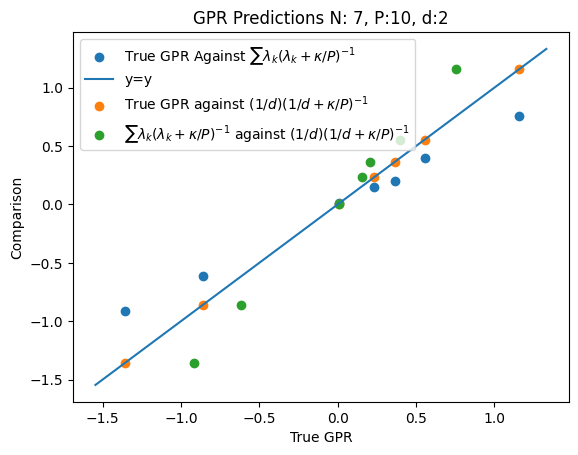

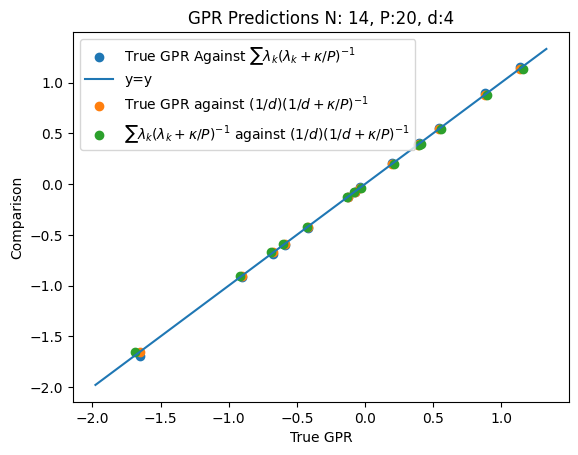

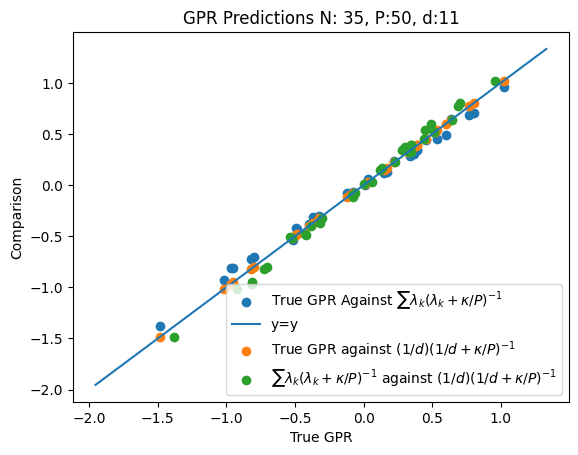

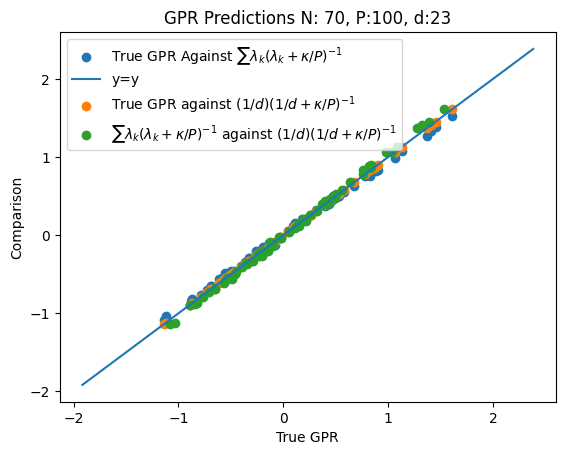

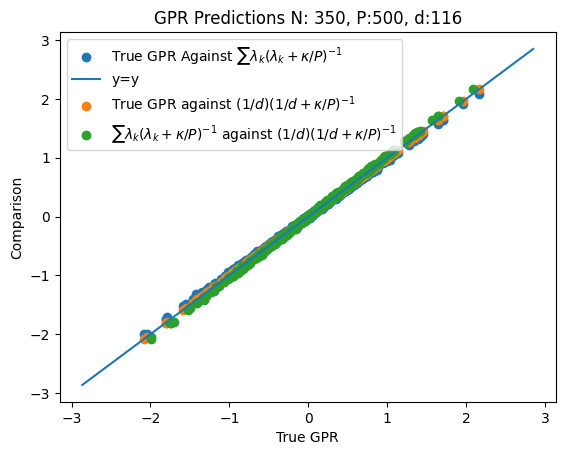

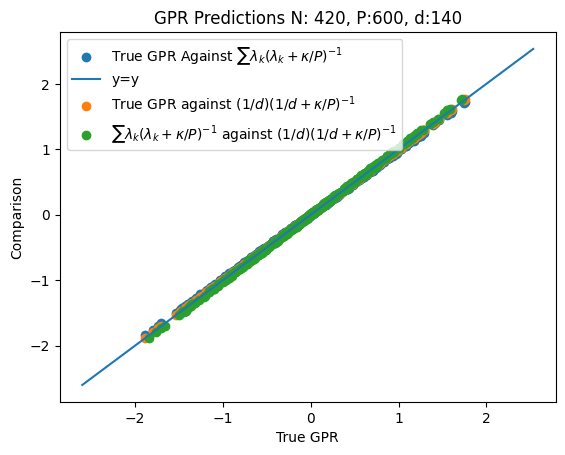

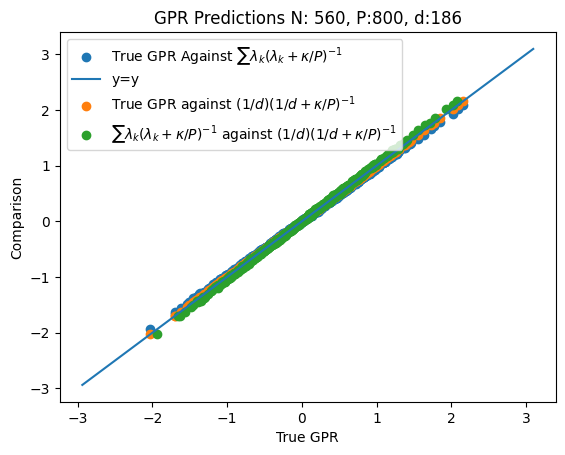

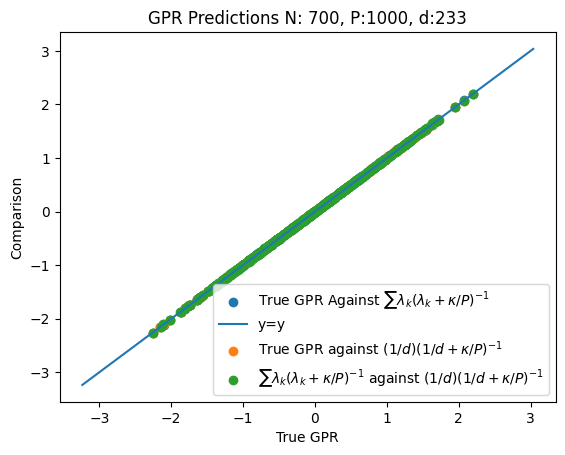

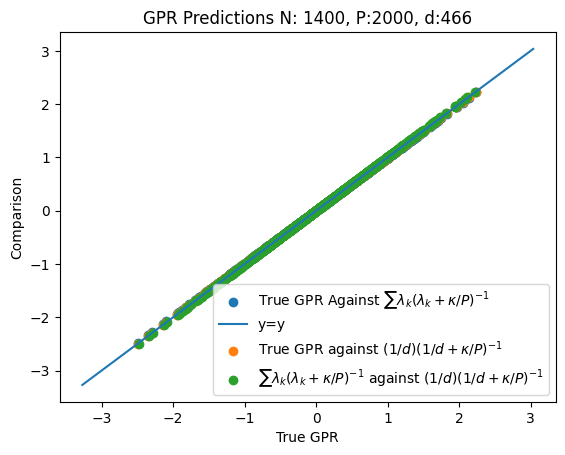

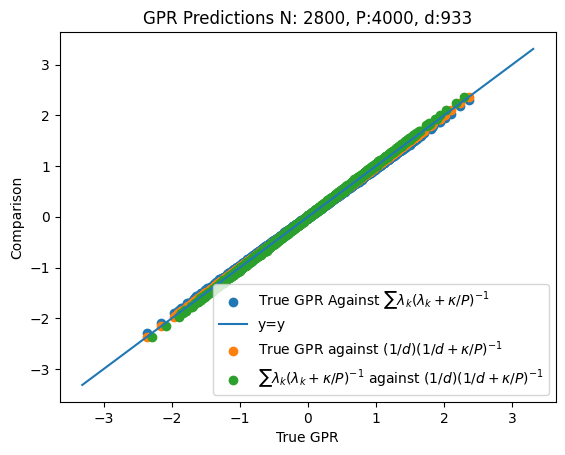

In [20]:
import math
import sys
import torch
import os
import matplotlib.pyplot as plt
import numpy as np
import json
import torch.nn as nn
INIT_SEED = 222

import torch
import matplotlib.pyplot as plt # For visualization, not part of the core function

# def gpr_data_averaged(phi, eigs, train_y, kappa, p):
#     """
#     Phi: P * k
#     Eigs: 1*k
#     ...
#     """
#     phi = phi / torch.sqrt(torch.einsum('ij,ij->j',phi, phi))

#     II = torch.eye(eigs.shape[0], dtype=torch.float).to('cuda')
#     LL = II * eigs/(eigs + kappa/p)
#     return torch.einsum('uk,kj,vj,v->u', phi, LL, phi, train_y)
    
def compute_nngp_kernel(phis_a, phis_b, eigenvalues):
    """
    Computes the NNGP kernel matrix K(A, B) given eigenfunctions and eigenvalues.

    Args:
        phis_a (torch.tensor): Eigenfunctions evaluated at points in set A.
                             Shape (num_points_a, num_eigenfunctions).
        phis_b (torch.tensor): Eigenfunctions evaluated at points in set B.
                             Shape (num_points_b, num_eigenfunctions).
        eigenvalues (np.ndarray): 1D array of NNGP eigenvalues (lambda_k).
                                  Shape (num_eigenfunctions,).

    Returns:
        np.ndarray: The NNGP kernel matrix K(A, B).
                    Shape (num_points_a, num_points_b).
    """
    # More efficient way often, by scaling phis_a columns directly:
    scaled_phis_a = phis_a * torch.sqrt(eigenvalues)
    scaled_phis_b = phis_b * torch.sqrt(eigenvalues)
    return scaled_phis_a @ scaled_phis_b.T


def compute_gpr_nngp_torch(
    phis_train,
    y_train,
    phis_test,
    eigenvalues,
    noise_variance
):
    """
    Computes the GPR predictive mean and variance using the NNGP kernel in PyTorch.

    Args:
        phis_train (torch.Tensor): Eigenfunctions evaluated at training points.
                                   Shape (num_train_points, num_eigenfunctions).
        y_train (torch.Tensor): Training target values.
                                Shape (num_train_points,).
        phis_test (torch.Tensor): Eigenfunctions evaluated at test points.
                                  Shape (num_test_points, num_eigenfunctions).
        eigenvalues (torch.Tensor): 1D tensor of NNGP eigenvalues (lambda_k).
                                    Shape (num_eigenfunctions,).
        noise_variance (float): The observation noise variance (sigma_noise^2).

    Returns:
        tuple: A tuple containing:
            - predictive_mean (torch.Tensor): Mean predictions for test points.
                                              Shape (num_test_points,).
            - predictive_variance (torch.Tensor): Variance predictions for test points.
                                                  Shape (num_test_points,).
    """
    num_train_points = phis_train.shape[0]
    num_test_points = phis_test.shape[0]
    
    # Ensure all tensors are on the same device
    device = phis_train.device
    y_train = y_train.to(device)
    phis_test = phis_test.to(device)
    eigenvalues = eigenvalues.to(device)

    K_xx = compute_nngp_kernel(phis_train, phis_train, eigenvalues) + noise_variance * torch.eye(num_train_points, device=device)

    # Compute the inverse of (K_DD + sigma_noise^2 * I) implicitly using Cholesky decomposition
    try:
        # L is the lower-triangular Cholesky factor
        L = torch.linalg.cholesky(K_xx)
        alpha = torch.linalg.solve(L.T, torch.linalg.solve(L, y_train))
    except RuntimeError as e:
        print(f"Warning: Cholesky decomposition failed ({e}). Falling back to direct inverse.")
        # Fallback for ill-conditioned matrices, less stable/efficient for large matrices
        K_xx_inv = torch.linalg.inv(K_xx)
        alpha = K_xx_inv @ y_train

    K_xD = compute_nngp_kernel(phis_test, phis_train, eigenvalues)

    # Compute Predictive Mean
    predictive_mean = K_xD @ alpha


    return predictive_mean
    
    
def gpr_dot_product_explicit(train_x, train_y, test_x, sigma_0_sq):
    """
    Computes Gaussian Process Regression mean and standard deviation using explicit formulas
    with a Dot Product Kernel.

    Args:
        train_x (torch.Tensor): N_train x D tensor of training input features.
        train_y (torch.Tensor): N_train x 1 tensor of training target values.
        test_x (torch.Tensor): N_test x D tensor of test input features.
        sigma_0_sq (float or torch.Tensor): The sigma_0^2 hyperparameter for the DotProduct kernel.
                                            This is NOT trained, you provide its value.
        noise_var (float or torch.Tensor): The observational noise variance (added to diagonal).
                                           This is NOT trained, you provide its value.

    Returns:
        tuple: (mu_pred, sigma_pred)
            mu_pred (torch.Tensor): N_test x 1 tensor of predicted means.
            sigma_pred (torch.Tensor): N_test x 1 tensor of predicted standard deviations.
    """

  
    sigma_0_sq = torch.tensor(sigma_0_sq, dtype=torch.float32, device=train_x.device)

    # 1. Define the DotProduct kernel function (helper within the main function)
    def dot_product_kernel_torch(X1, X2):
        """
        Computes the DotProduct kernel matrix K(X1, X2) using PyTorch.
        k(xi, xj) = xi @ xj.T
        """
        a = X1 / X1.shape[1]**0.5
        b = X2 / X2.shape[1]**0.5
        return a @ b.T

    K_xx = dot_product_kernel_torch(train_x, train_x) + sigma_0_sq * torch.eye(train_x.shape[0], device=train_x.device)

    K_xstar_x = dot_product_kernel_torch(test_x, train_x)

    jitter = 1e-6 * torch.eye(train_x.shape[0], device=train_x.device)
    try:
        K_xx_inv = torch.linalg.inv(K_xx + jitter)
    except torch.linalg.LinAlgError as e:
        print(f"Error: K_xx is singular or ill-conditioned even with jitter: {e}")
        raise

    # 4. Predict Mean (mu_pred)
    # Formula: mu_pred = K(X_test, X_train) @ K(X_train, X_train)^-1 @ y_train
    mu_pred = K_xstar_x @ K_xx_inv @ train_y

    return mu_pred

class FCN_2_layers(nn.Module):
      def __init__(self, d,N,init_out,init_hidden,activation, init_seed=None):
        super().__init__()
        if init_seed is not None:
            torch.manual_seed(INIT_SEED)
        self.lin1 = nn.Linear(d,N, bias=False)
        self.lin2 = nn.Linear(N,1, bias=False)
        self.activation=activation
        self.N = N
        self.d = d
        #np.random.seed(5)
        nn.init.normal_(self.lin1.weight,0,(init_hidden)**0.5)
        nn.init.normal_(self.lin2.weight,0,(init_out)**0.5)

      def forward(self, x):
        x = self.lin1(x)

        res = self.lin2(torch.flatten(x, start_dim=1))
        return res


def activation(x):
    return x

current_dir = os.path.dirname(os.path.abspath('.'))
parent_dir = os.path.dirname(current_dir)
sys.path.append(parent_dir)

#   # I trained one network per set of hyperparameters
#   def find_net0_files_os_walk(parent_dir):
#       found_files = []
#       for root, dir, files in os.walk(parent_dir):
#           for file in files:
#               if file == 'netnum_0':  # Or 'net₀' if that's the exact character
#                   found_files.append(os.path.join(root, file))
#       return found_files

def find_net0_files_os_walk(base_dir = "/akiva/gpnettrain/"):
    """
    Finds files named 'netnum_0' within subdirectories of a base directory
    (defaulting to 'gptnettrain') that start with 'network_ensemble_300000'.

    Args:
        base_dir (str): The base directory to start the search from (e.g., 'gptnettrain').

    Returns:
        list[str]: A list of full paths to all found 'netnum_0' files
                   that meet the specified subdirectory condition.
                   Returns an empty list if the base directory does not exist
                   or no such files are found.
    """
    found_files = []
    target_subdir_prefix = "network_ensemble_20250612"

    if not os.path.isdir(base_dir):
        print(f"Error: The base directory '{base_dir}' does not exist.")
        return []

    # First, identify the direct subdirectories that match the prefix
    qualifying_subdirs = []
    try:
        for entry in os.listdir(base_dir):
            full_path = os.path.join(base_dir, entry)
            if os.path.isdir(full_path) and entry.startswith(target_subdir_prefix):
                qualifying_subdirs.append(full_path)
    except OSError as e:
        print(f"Error accessing directory '{base_dir}': {e}")
        return []

    if not qualifying_subdirs:
        print(f"No subdirectories starting with '{target_subdir_prefix}' found directly under '{base_dir}'.")
        return []

    # Now, walk through each of these specific subdirectories
    for subdir_to_explore in qualifying_subdirs:
        for root, _, files in os.walk(subdir_to_explore):
            for filename in files:
                if filename == "netnum_0":
                    full_path = os.path.join(root, filename)
                    found_files.append(full_path)

    return found_files


def get_data(d,n,seed):
    np.random.seed(seed)
    X = torch.tensor(np.random.normal(loc=0,scale=1.,size=(n,1,d))).to(dtype=torch.float32)
    return X

Ps = [10, 20, 50, 100, 500, 600, 800, 1000, 2000, 4000]
Ns = [int(P * 0.7) for P in Ps]
Ds = [int(H / 3) for H in Ns]


train_seed = 563
test_seed = 10
theory_eigs_path = '/home/akiva/FCNX-Ensembling/GPExps/theory_eigs.json'


Menagerie_dir = os.path.join('/home/akiva/gpnettrain')
theory = None
with open(theory_eigs_path,'r') as f:
    theory = json.load(f)
lH_diffs = []
nets = find_net0_files_os_walk(Menagerie_dir)

nets = sorted(nets, key=lambda x: os.path.getctime(x))
eigs = []
for i in range(len(nets)): 
    n = torch.load(nets[i])

    
    W1 = n.lin1.weight.detach()
    
    P = Ps[i]
    N = Ns[i]
    d = Ds[i]
    X = get_data(d, N, train_seed).to('cuda') # this is the train seed used in net.py
    X = X.squeeze()
    W1 = n.lin1.weight.detach()
    
    f = (X @ W1.T) / (P**0.5)
    fm = torch.mean(f, dim=1)
    hh = torch.einsum('ji,ki->jk', f, f)/N 
    Ls = torch.einsum('uj,uv,vj->j', X, hh, X) / P
    norm = torch.einsum('ij,ij->j',X, X) / P
    lsT = Ls/norm
    ls =lsT.cpu().numpy()
    eigs.append(ls)
    X_test_ = get_data(d, N, test_seed).to('cuda')
    
    X_test = X_test_.squeeze()
    Xn = X_test.cpu().numpy()

    print(f'Computed eig: {lsT[0]}, Actual: {1/d}')
    
    
    true_gpr = gpr_dot_product_explicit(X, X[:,0], X_test, 1.0).cpu().numpy()
    mu_gpr = compute_gpr_nngp_torch(X, X[:,0], X_test, lsT, 1.0).cpu().numpy()
    
    perfect_gpr = compute_gpr_nngp_torch(X, X[:,0], X_test, lsT * 0 + 1.0/d,  1.0).cpu().numpy()
    tru_y =  X_test[:,0].cpu().numpy()


    print(true_gpr[0])
    print(mu_gpr[0])
    print('---')
    
    plt.figure()
    plt.title(f"GPR Predictions N: {N}, P:{P}, d:{d}")
    plt.scatter(true_gpr, mu_gpr, label="True GPR Against $\sum \lambda_k(\lambda_k + \kappa/P)^{-1}$")
    plt.plot(np.sort(tru_y), np.sort(tru_y), label="y=y")
    plt.scatter(true_gpr, perfect_gpr, label="True GPR against $(1/d)(1/d+\kappa/P)^{-1}$")
    plt.scatter(mu_gpr, perfect_gpr, label="$\sum \lambda_k(\lambda_k + \kappa/P)^{-1}$ against $(1/d)(1/d+\kappa/P)^{-1}$")

    plt.xlabel("True GPR")
    plt.ylabel("Comparison")
    plt.legend()    

    theorylHp = float(theory["perps"][i][1])
    theorylHT = float(theory["targ"][i][1])
    lH_diff = ls[0] - theorylHp
    lH_diffs.append(lH_diff)
    # print(f'P: {P}, N:{N}, d:{d}')
    # print(f'Emp   : {np.mean(ls): .8f}, std: {np.std(ls): .8f}')
    # print(f'Theory: {(1/d): .8f}')
    # print(f'FLT   : {theorylHT: .8f}')
    # print(f'FLp   : {theorylHp: .8f}')
    # print(f'Diff  : {lH_diff: .8f}')
    # print("------------------------")
    # What do I actually want to compute?
    # The centering of the eigenvalues around 
    # their expected value, as P, N, d grow





    


/tmp/ipykernel_3648935/344257195.py:267: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  n = torch.load(nets[i])


Computed eig: 0.06082724779844284, Actual: 1.0
tensor([0.0608], device='cuda:0')
0.85343367
0.13040935
P: 10, N:4, d:1
Emp   :  0.06082725, std: 0.0
---
Computed eig: 0.6511015892028809, Actual: 1.0
tensor([0.6511], device='cuda:0')
1.2544098
1.2166241
P: 20, N:8, d:1
Emp   :  0.65110159, std: 0.0
---
Computed eig: 0.15159687399864197, Actual: 0.3333333333333333
tensor([0.0829, 0.2547, 0.1172], device='cuda:0')
1.1205847
0.73777294
P: 50, N:20, d:3
Emp   :  0.15159687, std: 0.07420927286148071
---
Computed eig: 0.11651605367660522, Actual: 0.2
tensor([0.0918, 0.1072, 0.1652, 0.1005, 0.1177], device='cuda:0')
1.1467755
0.9795828
P: 100, N:40, d:5
Emp   :  0.11651605, std: 0.02578302100300789
---
Computed eig: 0.0205102376639843, Actual: 0.047619047619047616
tensor([0.0221, 0.0253, 0.0222, 0.0201, 0.0169, 0.0273, 0.0194, 0.0232, 0.0217,
        0.0189, 0.0244, 0.0193, 0.0194, 0.0198, 0.0147, 0.0210, 0.0162, 0.0178,
        0.0222, 0.0180, 0.0208], device='cuda:0')
1.1723335
1.0335681
P: 

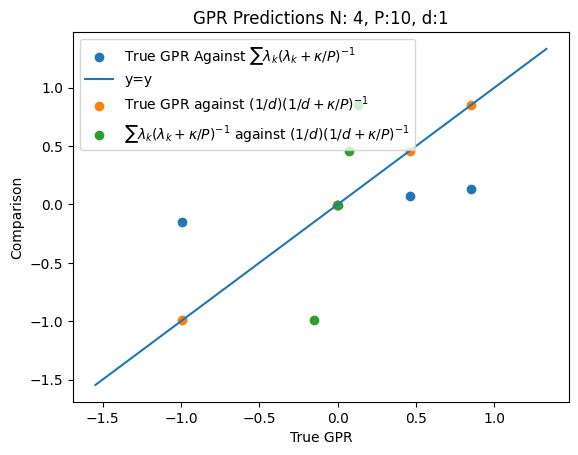

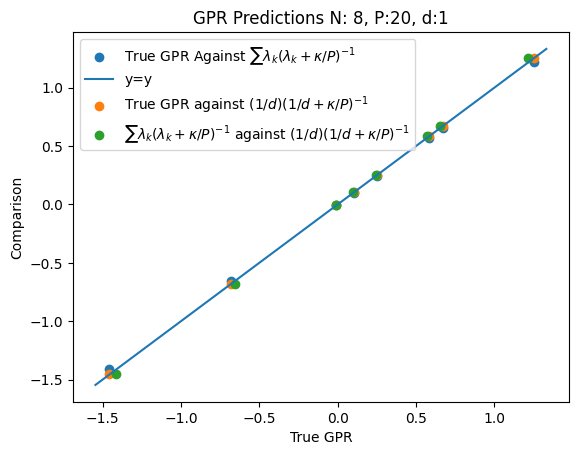

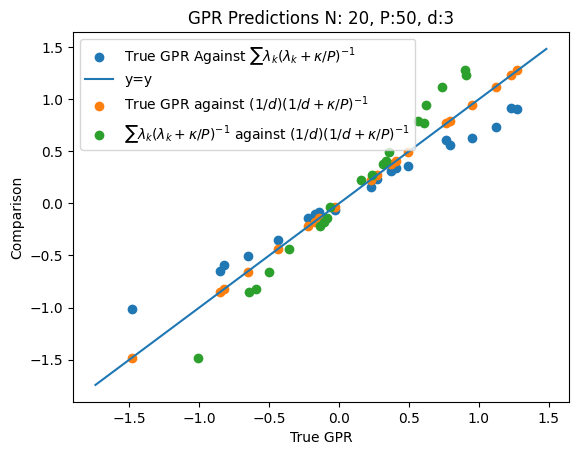

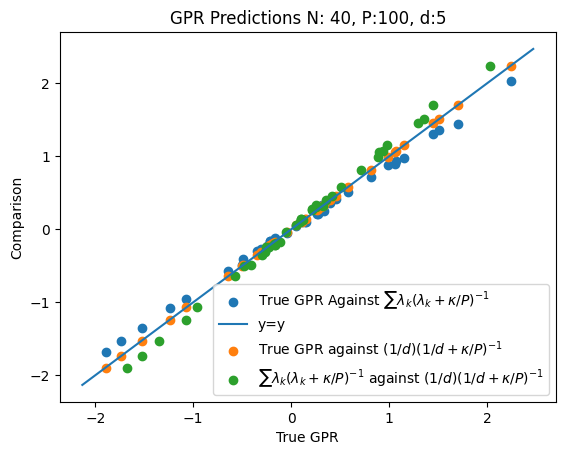

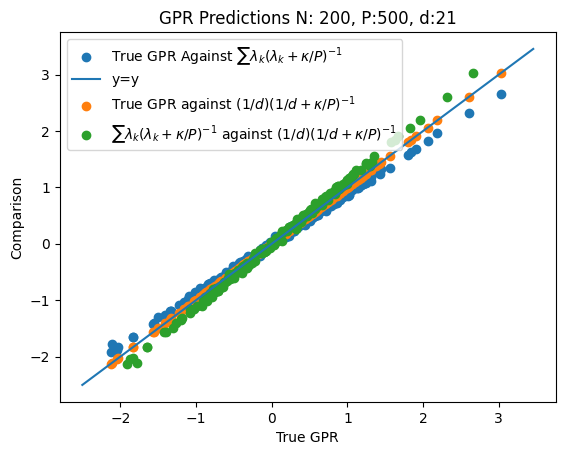

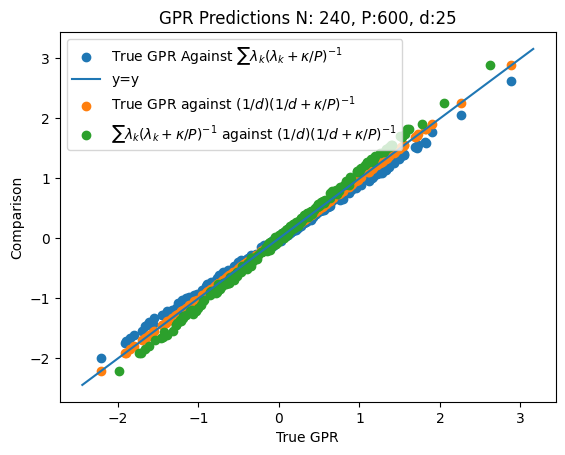

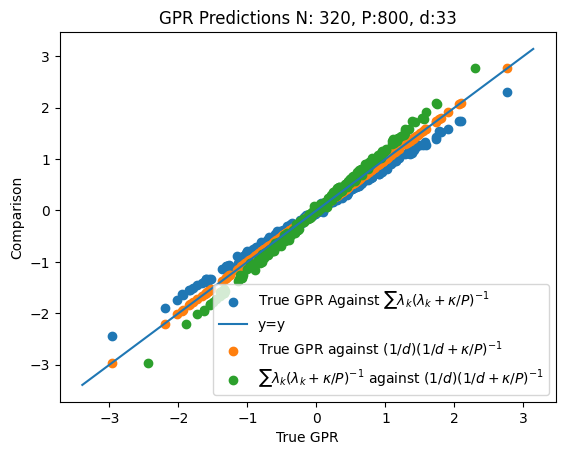

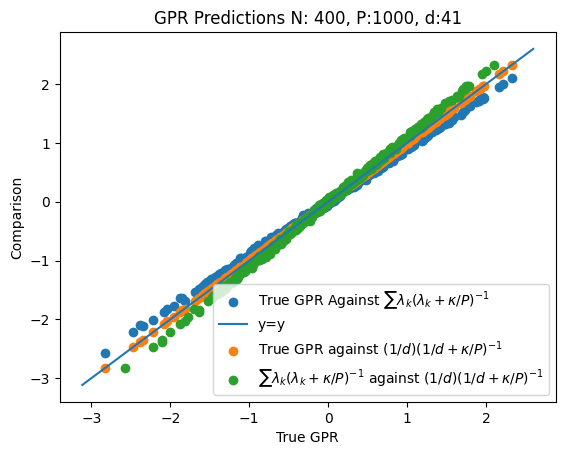

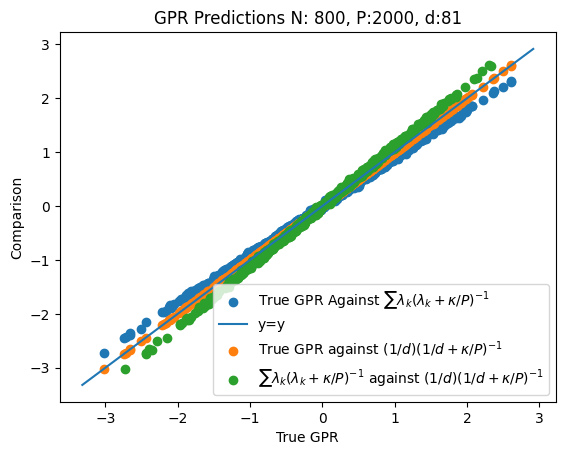

In [18]:
import math
import sys
import torch
import os
import matplotlib.pyplot as plt
import numpy as np
import json
import torch.nn as nn
INIT_SEED = 222

import torch
import matplotlib.pyplot as plt # For visualization, not part of the core function

# def gpr_data_averaged(phi, eigs, train_y, kappa, p):
#     """
#     Phi: P * k
#     Eigs: 1*k
#     ...
#     """
#     phi = phi / torch.sqrt(torch.einsum('ij,ij->j',phi, phi))

#     II = torch.eye(eigs.shape[0], dtype=torch.float).to('cuda')
#     LL = II * eigs/(eigs + kappa/p)
#     return torch.einsum('uk,kj,vj,v->u', phi, LL, phi, train_y)
    
def compute_nngp_kernel(phis_a, phis_b, eigenvalues):
    """
    Computes the NNGP kernel matrix K(A, B) given eigenfunctions and eigenvalues.

    Args:
        phis_a (torch.tensor): Eigenfunctions evaluated at points in set A.
                             Shape (num_points_a, num_eigenfunctions).
        phis_b (torch.tensor): Eigenfunctions evaluated at points in set B.
                             Shape (num_points_b, num_eigenfunctions).
        eigenvalues (np.ndarray): 1D array of NNGP eigenvalues (lambda_k).
                                  Shape (num_eigenfunctions,).

    Returns:
        np.ndarray: The NNGP kernel matrix K(A, B).
                    Shape (num_points_a, num_points_b).
    """
    # More efficient way often, by scaling phis_a columns directly:
    scaled_phis_a = phis_a * torch.sqrt(eigenvalues)
    scaled_phis_b = phis_b * torch.sqrt(eigenvalues)
    return scaled_phis_a @ scaled_phis_b.T


def compute_gpr_nngp_torch(
    phis_train,
    y_train,
    phis_test,
    eigenvalues,
    noise_variance
):
    """
    Computes the GPR predictive mean and variance using the NNGP kernel in PyTorch.

    Args:
        phis_train (torch.Tensor): Eigenfunctions evaluated at training points.
                                   Shape (num_train_points, num_eigenfunctions).
        y_train (torch.Tensor): Training target values.
                                Shape (num_train_points,).
        phis_test (torch.Tensor): Eigenfunctions evaluated at test points.
                                  Shape (num_test_points, num_eigenfunctions).
        eigenvalues (torch.Tensor): 1D tensor of NNGP eigenvalues (lambda_k).
                                    Shape (num_eigenfunctions,).
        noise_variance (float): The observation noise variance (sigma_noise^2).

    Returns:
        tuple: A tuple containing:
            - predictive_mean (torch.Tensor): Mean predictions for test points.
                                              Shape (num_test_points,).
            - predictive_variance (torch.Tensor): Variance predictions for test points.
                                                  Shape (num_test_points,).
    """
    num_train_points = phis_train.shape[0]
    num_test_points = phis_test.shape[0]
    
    # Ensure all tensors are on the same device
    device = phis_train.device
    y_train = y_train.to(device)
    phis_test = phis_test.to(device)
    eigenvalues = eigenvalues.to(device)

    K_xx = compute_nngp_kernel(phis_train, phis_train, eigenvalues) + noise_variance * torch.eye(num_train_points, device=device)

    # Compute the inverse of (K_DD + sigma_noise^2 * I) implicitly using Cholesky decomposition
    try:
        # L is the lower-triangular Cholesky factor
        L = torch.linalg.cholesky(K_xx)
        alpha = torch.linalg.solve(L.T, torch.linalg.solve(L, y_train))
    except RuntimeError as e:
        print(f"Warning: Cholesky decomposition failed ({e}). Falling back to direct inverse.")
        # Fallback for ill-conditioned matrices, less stable/efficient for large matrices
        K_xx_inv = torch.linalg.inv(K_DD_noisy)
        alpha = K_DD_noisy_inv @ y_train

    K_xD = compute_nngp_kernel(phis_test, phis_train, eigenvalues)

    # Compute Predictive Mean
    predictive_mean = K_xD @ alpha


    return predictive_mean
    
    
def gpr_dot_product_explicit(train_x, train_y, test_x, sigma_0_sq):
    """
    Computes Gaussian Process Regression mean and standard deviation using explicit formulas
    with a Dot Product Kernel.

    Args:
        train_x (torch.Tensor): N_train x D tensor of training input features.
        train_y (torch.Tensor): N_train x 1 tensor of training target values.
        test_x (torch.Tensor): N_test x D tensor of test input features.
        sigma_0_sq (float or torch.Tensor): The sigma_0^2 hyperparameter for the DotProduct kernel.
                                            This is NOT trained, you provide its value.
        noise_var (float or torch.Tensor): The observational noise variance (added to diagonal).
                                           This is NOT trained, you provide its value.

    Returns:
        tuple: (mu_pred, sigma_pred)
            mu_pred (torch.Tensor): N_test x 1 tensor of predicted means.
            sigma_pred (torch.Tensor): N_test x 1 tensor of predicted standard deviations.
    """

  
    sigma_0_sq = torch.tensor(sigma_0_sq, dtype=torch.float32, device=train_x.device)

    # 1. Define the DotProduct kernel function (helper within the main function)
    def dot_product_kernel_torch(X1, X2):
        """
        Computes the DotProduct kernel matrix K(X1, X2) using PyTorch.
        k(xi, xj) = xi @ xj.T
        """
        a = X1 / X1.shape[1]**0.5
        b = X2 / X2.shape[1]**0.5
        return a @ b.T

    K_xx = dot_product_kernel_torch(train_x, train_x) + sigma_0_sq * torch.eye(train_x.shape[0], device=train_x.device)

    K_xstar_x = dot_product_kernel_torch(test_x, train_x)

    jitter = 1e-6 * torch.eye(train_x.shape[0], device=train_x.device)
    try:
        K_xx_inv = torch.linalg.inv(K_xx + jitter)
    except torch.linalg.LinAlgError as e:
        print(f"Error: K_xx is singular or ill-conditioned even with jitter: {e}")
        raise

    # 4. Predict Mean (mu_pred)
    # Formula: mu_pred = K(X_test, X_train) @ K(X_train, X_train)^-1 @ y_train
    mu_pred = K_xstar_x @ K_xx_inv @ train_y

    return mu_pred

class FCN_2_layers(nn.Module):
      def __init__(self, d,N,init_out,init_hidden,activation, init_seed=None):
        super().__init__()
        if init_seed is not None:
            torch.manual_seed(INIT_SEED)
        self.lin1 = nn.Linear(d,N, bias=False)
        self.lin2 = nn.Linear(N,1, bias=False)
        self.activation=activation
        self.N = N
        self.d = d
        #np.random.seed(5)
        nn.init.normal_(self.lin1.weight,0,(init_hidden)**0.5)
        nn.init.normal_(self.lin2.weight,0,(init_out)**0.5)

      def forward(self, x):
        x = self.lin1(x)

        res = self.lin2(torch.flatten(x, start_dim=1))
        return res


def activation(x):
    return x

current_dir = os.path.dirname(os.path.abspath('.'))
parent_dir = os.path.dirname(current_dir)
sys.path.append(parent_dir)

#   # I trained one network per set of hyperparameters
#   def find_net0_files_os_walk(parent_dir):
#       found_files = []
#       for root, dir, files in os.walk(parent_dir):
#           for file in files:
#               if file == 'netnum_0':  # Or 'net₀' if that's the exact character
#                   found_files.append(os.path.join(root, file))
#       return found_files

def find_net0_files_os_walk(base_dir = "/akiva/gpnettrain/"):
    """
    Finds files named 'netnum_0' within subdirectories of a base directory
    (defaulting to 'gptnettrain') that start with 'network_ensemble_300000'.

    Args:
        base_dir (str): The base directory to start the search from (e.g., 'gptnettrain').

    Returns:
        list[str]: A list of full paths to all found 'netnum_0' files
                   that meet the specified subdirectory condition.
                   Returns an empty list if the base directory does not exist
                   or no such files are found.
    """
    found_files = []
    target_subdir_prefix = "large_epochs_GP_3000000_20250615_235934"

    if not os.path.isdir(base_dir):
        print(f"Error: The base directory '{base_dir}' does not exist.")
        return []

    # First, identify the direct subdirectories that match the prefix
    qualifying_subdirs = []
    try:
        for entry in os.listdir(base_dir):
            full_path = os.path.join(base_dir, entry)
            if os.path.isdir(full_path) and entry.startswith(target_subdir_prefix):
                qualifying_subdirs.append(full_path)
    except OSError as e:
        print(f"Error accessing directory '{base_dir}': {e}")
        return []

    if not qualifying_subdirs:
        print(f"No subdirectories starting with '{target_subdir_prefix}' found directly under '{base_dir}'.")
        return []

    # Now, walk through each of these specific subdirectories
    for subdir_to_explore in qualifying_subdirs:
        for root, _, files in os.walk(subdir_to_explore):
            for filename in files:
                if filename == "netnum_0":
                    full_path = os.path.join(root, filename)
                    found_files.append(full_path)

    return found_files


def get_data(d,n,seed):
    np.random.seed(seed)
    X = torch.tensor(np.random.normal(loc=0,scale=1.,size=(n,1,d))).to(dtype=torch.float32)
    return X

Ps = [10, 20, 50, 100, 500, 600, 800, 1000, 2000, 4000, 10000]
Ns = [math.ceil(P * 0.4) for P in Ps] 
Ds = [math.ceil(H* 0.1+.1) for H in Ns]



train_seed = 563
test_seed = 10
theory_eigs_path = '/home/akiva/FCNX-Ensembling/GPExps/theory_eigs.json'


Menagerie_dir = os.path.join('/home/akiva/gpnettrain')
theory = None
with open(theory_eigs_path,'r') as f:
    theory = json.load(f)
lH_diffs = []
nets = find_net0_files_os_walk(Menagerie_dir)

nets = sorted(nets, key=lambda x: os.path.getctime(x))
eigs = []
for i in range(len(nets)): 
    n = torch.load(nets[i])

    
    W1 = n.lin1.weight.detach()
    
    P = Ps[i]
    N = Ns[i]
    d = Ds[i]
    X = get_data(d, N, train_seed).to('cuda') # this is the train seed used in net.py
    
    X = X.squeeze(1)
    
    W1 = n.lin1.weight.detach()
    f = (X @ W1.T) / (P**0.5)
    fm = torch.mean(f, dim=1)
    hh = torch.einsum('ji,ki->jk', f, f)/N
    Ls = torch.einsum('uj,uv,vj->j', X, hh, X) / P
    norm = torch.einsum('ij,ij->j',X, X) / P
    lsT = Ls/norm
    ls =lsT.cpu().numpy()
    eigs.append(ls)
    X_test_ = get_data(d, N, test_seed).to('cuda')
    
    X_test = X_test_.squeeze(1)
    Xn = X_test.cpu().numpy()

    print(f'Computed eig: {torch.mean(lsT)}, Actual: {1/d}')
    print(lsT)
    
    
    true_gpr = gpr_dot_product_explicit(X, X[:,0], X_test, 1.0).cpu().numpy()
    mu_gpr = compute_gpr_nngp_torch(X, X[:,0], X_test, lsT, 1.0).cpu().numpy()
    
    perfect_gpr = compute_gpr_nngp_torch(X, X[:,0], X_test, lsT * 0 + 1.0/d,  1.0).cpu().numpy()
    tru_y =  X_test[:,0].cpu().numpy()


    print(true_gpr[0])
    print(mu_gpr[0])
    
    plt.figure()
    plt.title(f"GPR Predictions N: {N}, P:{P}, d:{d}")
    plt.scatter(true_gpr, mu_gpr, label="True GPR Against $\sum \lambda_k(\lambda_k + \kappa/P)^{-1}$")
    plt.plot(np.sort(tru_y), np.sort(tru_y), label="y=y")
    plt.scatter(true_gpr, perfect_gpr, label="True GPR against $(1/d)(1/d+\kappa/P)^{-1}$")
    plt.scatter(mu_gpr, perfect_gpr, label="$\sum \lambda_k(\lambda_k + \kappa/P)^{-1}$ against $(1/d)(1/d+\kappa/P)^{-1}$")

    plt.xlabel("True GPR")
    plt.ylabel("Comparison")
    plt.legend()    

    lH_diffs.append(lH_diff)
    print(f'P: {P}, N:{N}, d:{d}')
    print(f'Emp   : {np.mean(ls): .8f}, std: {np.std(ls)}')
    # print(f'Theory: {(1/d): .8f}')
    print('---')

